## Generate noisy data from constructed phantom, and reconstruct phantom

In [1]:
import numpy as np
import scipy as sp
import func
import phantom
import KTCFwd
import glob
import matplotlib.pyplot as plt
import KTCFwd
import KTCMeshing
import KTCRegularization
import KTCPlotting
import KTCScoring
import KTCAux
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import laplace
from scipy.stats.stats import pearsonr 
Nel = 32
input_folder = 'TrainingData'
groundtruth_folder = 'GroundTruths'
noise_level = 1
categoryNbr = 1
z = (1e-6) * np.ones((Nel, 1))

C:\Users\marti\AppData\Local\Temp\ipykernel_78088\3227231284.py:17: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [27]:
# Calculate system (bias) error. 
error_system = 0.00001*func.system_error(groundtruth_folder, input_folder,categoryNbr, Nel, average_error = False)

In [28]:
# Generate measurement
Measurement1, Measurement_nfree, sigma_class, sigma = func.GenerateMeasurement(input_folder,
groundtruth_folder, noise_level, categoryNbr,error_system)

In [29]:
# Get the reference measurement and true measurement
data_number = 1
mat_dict = sp.io.loadmat(input_folder + '/ref.mat') #load the reference data
mat_files = glob.glob(input_folder + '/data*.mat') # load the real data
reference = mat_dict['Uelref']
mat_dict2 = sp.io.loadmat(mat_files[data_number-1])
Uel = mat_dict2["Uel"]

## Do reconstruction of the generated data

(65536,)


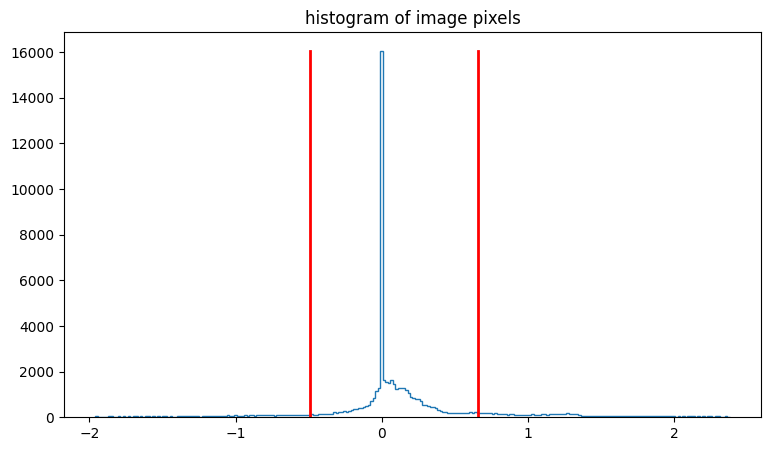

In [34]:
# Decide on which measurement, we do the reconstruction from
Measurement = Measurement1 # Use generated noisy data
#Measurement = Measurement_nfree # Use use generated noise-free data
#Measurement = Uel # Use real data
Mesh, Mesh2, vincl, Mpat, Injref = func.SetupMesh(categoryNbr, Nel,input_folder)
N_iter = 1
sigma0 = np.array(0.8*np.ones((len(Mesh.g), 1))) #linearization point
sigma0_init = sigma0
corrlength = 1 * 0.115 #used in the prior
var_sigma = 0.05 ** 2 #prior variance
mean_sigma = sigma0
smprior = KTCRegularization.SMPrior(Mesh.g, corrlength, var_sigma, mean_sigma)

# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)

vincl = vincl.T.flatten()
# set up the noise model for inversion
noise_std1 = 0.05;  # standard deviation for first noise component (relative to each voltage measurement)
noise_std2 = 0.01;  # standard deviation for second noise component (relative to the largest voltage measurement)
solver.SetInvGamma(noise_std1, noise_std2, Measurement)

# Compute the difference of the measured real vs measured reference data
deltaU = Measurement - reference

mask = np.array(vincl, bool) # Mask the removed electrodes
#Usim = solver.SolveForward(sigma0, z) + (Measurement - solver.SolveForward(sigma0,z)) #forward solution at the linearization point with correction term
J = solver.Jacobian(sigma0, z)
deltareco = np.linalg.solve(J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ J + smprior.L.T @ smprior.L,J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ deltaU[vincl])
sigma = np.array(sigma0 + deltareco) # Take 1 step in Newton like algorithm
sigma0_special, reconstruction = func.applyOtsu(sigma, Mesh,sigmavalues = (0.8,0.4,1.4))

deltareco = sigma - sigma0_init

deltareco_pixgrid = KTCAux.interpolateRecoToPixGrid(deltareco, Mesh) # Interpolate to picture

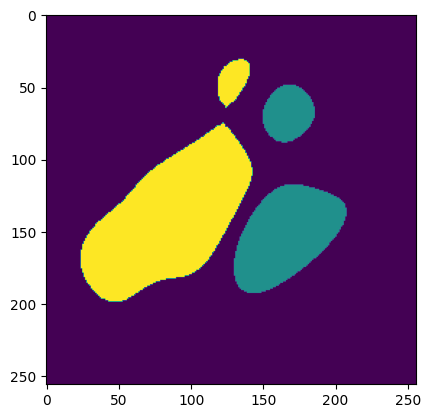

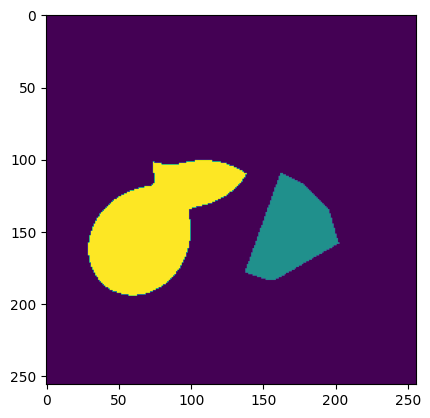

In [35]:
plt.imshow(reconstruction)
plt.figure()
plt.imshow(sigma_class)